In [ ]:
pip -q install transformers datasets wandb

In [ ]:
!nvidia-smi

Mon Sep 20 15:28:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# load tensorboard extension
%load_ext tensorboard

# Patronizing and Condescending Language Detection

We all are patronizing and condescending sometimes. And of course, we all are susceptible to be condescended and patronized by others. But some groups are, unfortunately, more used to be referred to with this undervaluing treatment. The so-called vulnerable communities seem to be the perfect target for charity and pity-driven texts, condescension and patronization in news stories.

PCL is often unvoluntary and unconscious and the authors using such language are usually trying to help the communities in need, by raising awareness, moving the audience to action or standing for the rights of the under-represented. But PCL can potentially be very harmful, as it feeds tereotypes, routinizes discrimination and drives to greater exclusion.

Resource:
- https://arxiv.org/pdf/2011.08320.pdf
- https://competitions.codalab.org/competitions/34344
- https://sites.google.com/view/pcl-detection-semeval2022/


# The Task
The Patronizing and Condescending Language Detection Task is based on the paper Don't Patronize Me! An annotated Dataset with Patronizing and Condescending Language Towards Vulnerable Communities (Perez-Almendros et al., 2020).

The aim of this task is to identify PCL, and to categorize the linguistic techniques used to express it, specifically when referring to communities identified as being vulnerable to unfair treatment in the media.

Participants are provided with sentences in context (paragraphs), extracted from news articles, in which one or several predefined vulnerable communities are mentioned. The challenge is divided into two subtasks. 

<ul>
  <li>
  <b>Subtask 1:</b> Binary classification. Given a paragraph, a system must predict whether or not it contains any form of PCL. 
  </li>
  <li>
  <b>Subtask 2:</b> Multi-label classification. Given a paragraph, a system must identify which PCL categories express the condescension*. 
  </li>
</ul>

Baselines from [the paper](https://arxiv.org/pdf/2011.08320.pdf):


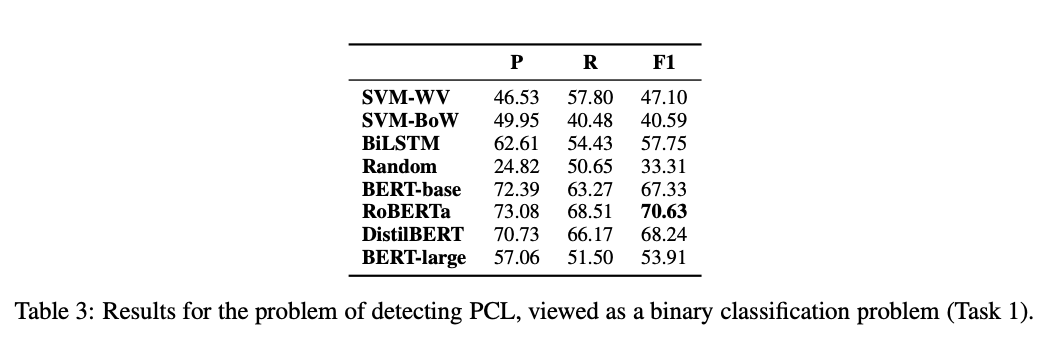


## Prepare Dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_categories = pd.read_csv('dontpatronizeme_categories.tsv', sep='\t')
df_categories['number_of_annotators_agreeing_in_that_label']

0       2.0
1       2.0
2       2.0
3       2.0
4       2.0
       ... 
2681    1.0
2682    1.0
2683    1.0
2684    1.0
2685    1.0
Name: number_of_annotators_agreeing_in_that_label, Length: 2686, dtype: float64

In [ ]:
print(f"category_label NaN values : {df_categories['category_label'].isnull().sum()}")
print(f"span_tetx NaN values : {df_categories['span_text'].isnull().sum()}")

category_label NaN values : 1
span_tetx NaN values : 1


In [ ]:
df_categories = df_categories[df_categories['category_label'].notna()]
df_categories = df_categories[df_categories['span_text'].notna()]

In [ ]:
print(f"category_label NaN values : {df_categories['category_label'].isnull().sum()}")
print(f"span_tetx NaN values : {df_categories['span_text'].isnull().sum()}")

category_label NaN values : 0
span_tetx NaN values : 0


In [ ]:
a = df_categories['category_label'].astype('category')
df_categories['labels'] = a.cat.codes

In [ ]:
df_categories['labels'].unique()

array([6, 0, 4, 3, 1, 2, 5], dtype=int8)

In [ ]:
len(df_categories)

2685

## Multi-class Classification


In [ ]:
import os
os.environ['WANDB_PROJECT'] = 'pcl-binary'

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import RobertaTokenizer, BertTokenizer
from torch.utils.data import TensorDataset

from transformers import RobertaForSequenceClassification, BertForSequenceClassification

import seaborn as sns

In [ ]:
len(df_categories)

2685

In [ ]:
df_categories.isnull().sum()

paragraph_id                                   0
paragraph                                      0
keyword                                        0
country_code                                   0
span_start                                     0
span_end                                       0
span_text                                      0
category_label                                 0
number_of_annotators_agreeing_in_that_label    0
labels                                         0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


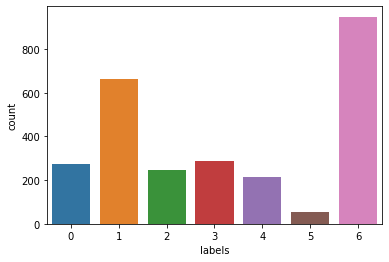

In [ ]:
sns.countplot(df_categories['labels']);

## Training using Huggingface API

In [ ]:
df_categories_selected = df_categories
def combine_features(row) :
  return '<s>'.join(row.drop(['paragraph','keyword','span_start','span_end','category_label','labels'],axis=0).apply(str).values)
df_categories_selected['combined_features'] = df_categories_selected.apply(combine_features, axis = 1)

In [ ]:
valid_size = 279
duplicate = df_categories_selected[df_categories['span_text'].duplicated()]
none_duplicate = df_categories_selected.drop(duplicate.index, axis=0)
df_categories_valid = none_duplicate.sample(valid_size, random_state = 42)
df_categories_train = df_categories_selected.drop(df_categories_valid.index, axis=0)
df_categories_train

,paragraph_id,paragraph,keyword,country_code,span_start,span_end,span_text,category_label,number_of_annotators_agreeing_in_that_label,labels,combined_features
0,@@14767805,We also know that they can benefit by receivin...,hopeless,us,64.0,101.0,someone who can help them understand,Unbalanced_power_relations,2.0,6,@@14767805<s>us<s>someone who can help them un...
1,@@14767805,We also know that they can benefit by receivin...,hopeless,us,358.0,434.0,someone who can help them plan for their needs...,Unbalanced_power_relations,2.0,6,@@14767805<s>us<s>someone who can help them pl...
2,@@14767805,We also know that they can benefit by receivin...,hopeless,us,0.0,35.0,We also know that they can benefit,Authority_voice,2.0,0,@@14767805<s>us<s>We also know that they can b...
3,@@14767805,We also know that they can benefit by receivin...,hopeless,us,175.0,236.0,someone who can help them put their situation ...,Unbalanced_power_relations,2.0,6,@@14767805<s>us<s>someone who can help them pu...
4,@@14767805,We also know that they can benefit by receivin...,hopeless,us,201.0,236.0,put their situation in perspective,Authority_voice,2.0,0,@@14767805<s>us<s>put their situation in persp...
...,...,...,...,...,...,...,...,...,...,...,...
2681,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,0.0,29.0,Touched much by their plight,Compassion,1.0,1,@@2559173<s>lk<s>Touched much by their plight<...
2682,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,31.0,315.0,Commanding Officer and all ranks of the 7 Sri ...,Unbalanced_power_relations,1.0,6,@@2559173<s>lk<s>Commanding Officer and all ra...
2683,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,153.0,205.0,gave a strong indication of hope for Ghanaian ...,Unbalanced_power_relations,1.0,6,@@1947926<s>gh<s>gave a strong indication of h...
2684,@@14806326,The NDC has always led the way in championing...,disabled,gh,2.0,74.0,The NDC has always led the way in championing ...,Unbalanced_power_relations,1.0,6,@@14806326<s>gh<s>The NDC has always led the w...


In [ ]:
from datasets import Dataset
raw_datasets_valid = Dataset.from_pandas(df_categories_valid[['combined_features','labels']])
raw_datasets_train = Dataset.from_pandas(df_categories_train[['combined_features','labels']])
raw_datasets_train

Dataset({
    features: ['combined_features', 'labels', '__index_level_0__'],
    num_rows: 2406
})

Because the labels are imbalanced, we split the data set in a stratified fashion, using this as the class labels.

In [ ]:
# FIXME: Ali - Idea: Try zero shot, few shot, fine-tuning with GPT-3
from transformers import AutoTokenizer
model_name = 'roberta-large'
# model_name = 'bert-base-uncased'
# model_name = 'roberta-large-openai-detector' #FIXME: Ali - Idea: Try other larger models
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["combined_features"], padding="max_length", truncation=True)

tokenized_datasets_train = raw_datasets_train.map(tokenize_function, batched=True)
tokenized_datasets_valid = raw_datasets_valid.map(tokenize_function, batched=True)
tokenized_datasets_train

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['__index_level_0__', 'attention_mask', 'combined_features', 'input_ids', 'labels'],
    num_rows: 2406
})

In [ ]:
small_dataset_size = 10
small_train_dataset = tokenized_datasets_train.shuffle(seed=42).select(range(small_dataset_size))
small_eval_dataset = tokenized_datasets_valid.shuffle(seed=42).select(range(small_dataset_size))
full_train_dataset = tokenized_datasets_train
full_eval_dataset = tokenized_datasets_valid

In [ ]:
# model_bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# model_bert

In [ ]:
# model_bert()

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7)

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [ ]:
from datasets import load_metric, list_metrics
# list_metrics()

In [ ]:
from transformers import TrainingArguments
run_name = 'roberta_large_lr1e-5'
# https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments
training_args = TrainingArguments(run_name, num_train_epochs=8,save_total_limit = 2, report_to=['tensorboard','wandb'], learning_rate=1e-5,
                                  evaluation_strategy= "epoch", per_device_train_batch_size=4, gradient_accumulation_steps=1, warmup_steps=1000, lr_scheduler_type='linear') 
# , resume_from_checkpoint='full_roberta_lr5e-5' , per_device_train_batch_size=4
# FIXME: Ali - Idea: use schedulers with different learning_rate (higher or lower) 
# TODO: Ali - add Gdrive to save checkpoints in gdrive
# TODO: Ali - use `resume_from_checkpoint` to load model from last checkpoint

In [ ]:
 from transformers import Trainer
import numpy as np
from datasets import load_metric

f1_metric = load_metric('f1')

# accuracy_metric = load_metric("accuracy")

Downloading:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

In [ ]:
# model.roberta.encoder

In [ ]:
# df_pcl_valid['labels'].values[:10]

In [ ]:
# f1_metric.compute(predictions=y_pred.predictions.argmax(axis=1), references=df_pcl_valid['labels'].values[10:20])

In [ ]:
from sklearn.metrics import f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {'f1': f1_score(labels, predictions, average='macro')}
    # return f1_metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model, args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
!nvidia-smi

Mon Sep 20 15:36:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |   2434MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Wandb accces code: 6eac997ed11cad663510778e5e1c33388cdac6c5
# swswswswsw

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache() sssssssssss

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, combined_features.
***** Running training *****
  Num examples = 2406
  Num Epochs = 8
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4816
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1
1,1.764500,1.318383,0.202014
2,1.261400,1.041829,0.409190
3,1.049900,0.989338,0.530982
4,0.883700,1.075929,0.564085
5,0.611800,1.306504,0.574855
6,0.498300,1.597257,0.566843
7,0.417900,1.849689,0.577691
8,0.359700,1.970165,0.572890


Saving model checkpoint to roberta_large_lr1e-5/checkpoint-500
Configuration saved in roberta_large_lr1e-5/checkpoint-500/config.json
Model weights saved in roberta_large_lr1e-5/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, combined_features.
***** Running Evaluation *****
  Num examples = 279
  Batch size = 8
Saving model checkpoint to roberta_large_lr1e-5/checkpoint-1000
Configuration saved in roberta_large_lr1e-5/checkpoint-1000/config.json
Model weights saved in roberta_large_lr1e-5/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, combined_features.
***** Running Evaluation *****
  Num examples = 279
  Batch size = 8
Saving model checkpoint to roberta_large_lr1e-5/checkpoint-15

TrainOutput(global_step=4816, training_loss=0.8059706909711971, metrics={'train_runtime': 7114.871, 'train_samples_per_second': 2.705, 'train_steps_per_second': 0.677, 'total_flos': 1.7938117921849344e+16, 'train_loss': 0.8059706909711971, 'epoch': 8.0})

In [ ]:
trainer.evaluate()

In [ ]:
y_pred = trainer.predict(small_eval_dataset)

In [ ]:
y_pred.predictions.argmax(axis=1)

In [ ]:
df_preds=pd.DataFrame(y_pred.label_ids)
df_preds

In [ ]:
# del trainer
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# For WandB results checkout https://wandb.ai/alipanahi/pcl-binary 
%tensorboard --logdir "roberta_large_lr5e-5"

In [ ]:
# mkdir -p /content/drive/MyDrive/full_roberta_lr5e-5/checkpoint-5500/

In [ ]:
# cp -r /content/full_roberta_lr5e-5/checkpoint-5500/ /content/drive/MyDrive/full_roberta_lr5e-5/checkpoint-5500/

In [ ]:
# import wandb
# wandb.init(project='pcl-binary')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_pcl_valid['labels'].values, df_preds.values, target_names=['0','1']))

In [ ]:
from sklearn.metrics import f1_score
f1_score(df_pcl_valid['labels'].values, df_preds.values, average='macro')

In [ ]:
df_pcl_valid['labels'].values[:10]